<a href="https://colab.research.google.com/github/tanushreer-7/Customer-Churn-Analysis/blob/main/CUSTOMER_CHURN_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP-1: IMPORTING NECESSARY PACKAGES**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve,f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# **STEP-2: LOAD THE DATASET**

In [2]:
df=pd.read_csv("/content/Final_Customer_Churn_Dataset.csv")
df.head()

,customer_name,age,gender,service_name,acc_creation_date,last_login,tenure,subscription_plan,ad_supported_plan,subscription_duration,...,average_watch_time,binge_watching,no_of_logins_perday,no_of_devices_used,content_type_preference,payment_type,customer_support_interaction,discounts_availed,renewal_status,rating
0,Hansika S,20,Female,Amazon Prime Video,01-03-2022,31-07-2024,943,Standard,No,913,...,1.20,No,1,1,Movies,Credit/Debit Card,No,Yes,Not Sure,4
1,Sam Jonhs,30,Male,Amazon Prime Video,10-05-2024,10-02-2025,275,Standard,No,30,...,1.20,No,1,4,Documentaries,Credit/Debit Card,No,Yes,Yes,4
2,Nisha Deka,30,Prefer not to say,Amazon Prime Video,02-12-2020,02-02-2025,1184,Basic,Yes,120,...,1.00,No,5,3,Reality Shows,Credit/Debit Card,No,Yes,No,4
3,Nasha,36,Other,Amazon Prime Video,01-08-2023,12-01-2025,530,Basic,No,180,...,1.93,No,7,3,Education,UPI,Yes,No,Yes,3
4,Sindhu,59,Female,Amazon Prime Video,05-05-2024,09-01-2025,0,Free,No,0,...,1.97,Yes,1,5,Education,Credit/Debit Card,Yes,Yes,No,3


# **STEP-3: PREPROCESSING THE DATASET**

In [3]:
#check for missing values
df.isnull().sum().sum()

np.int64(0)

In [4]:
# Show how many NaNs per column
df.isnull().sum().sort_values(ascending=False)

,0
customer_name,0
age,0
gender,0
service_name,0
acc_creation_date,0
last_login,0
tenure,0
subscription_plan,0
ad_supported_plan,0
subscription_duration,0


In [5]:
#converting the date column
df['acc_creation_date'] = pd.to_datetime(df['acc_creation_date'], format='%d-%m-%Y', errors='coerce')
df['last_login'] = pd.to_datetime(df['last_login'], format='%d-%m-%Y', errors='coerce')

In [6]:
#analyze the dataset
print("Index: \n",df.index)
print("\nColumn: \n",df.columns)
print("\nSize:",df.size)
print("\nShape:",df.shape)
print("\nData types: \n",df.dtypes)
print("\nDimension:",df.ndim)
print("\nMemory Usage: \n",df.memory_usage())
print("\nInfo :")
print(df.info())
print(df.describe())

Index: 
 RangeIndex(start=0, stop=125, step=1)

Column: 
 Index(['customer_name', 'age', 'gender', 'service_name', 'acc_creation_date',
       'last_login', 'tenure', 'subscription_plan', 'ad_supported_plan',
       'subscription_duration', 'free_trail_used', 'free_trail_duration',
       'usage_hours', 'average_watch_time', 'binge_watching',
       'no_of_logins_perday', 'no_of_devices_used', 'content_type_preference',
       'payment_type', 'customer_support_interaction', 'discounts_availed',
       'renewal_status', 'rating'],
      dtype='object')

Size: 2875

Shape: (125, 23)

Data types: 
 customer_name                           object
age                                      int64
gender                                  object
service_name                            object
acc_creation_date               datetime64[ns]
last_login                      datetime64[ns]
tenure                                   int64
subscription_plan                       object
ad_supported_plan    

In [7]:
#find the target variable
#convert date fields to total number of days
df['acc_creation_date'] = pd.to_datetime(df['acc_creation_date'], format='%d-%m-%y', errors='coerce')
df['last_login'] = pd.to_datetime(df['last_login'], format='%d-%m-%y', errors='coerce')
today = pd.to_datetime("today")
df['days_since_last_login'] = (today - df['last_login']).dt.days

#rule-based churn detection logic for different services
def detect_churn(row):
    if row['service_name'].lower() == 'Netflix' or 'Amazon Prime Video ' or 'Google Meet' or 'JioHotstar' or 'Youtube' or 'Youtube Studio'or 'Facebook' or 'TikTok':
        return 1 if (
    str(row['renewal_status']).lower() in ['No', 'Not Sure'] or
    row['usage_hours'] < 0.5 or
    row['average_watch_time'] < 1 or
    row['days_since_last_login'] > 10 or
    (row['customer_support_interaction'] == 'No' and row['discounts_availed'] == 'No' and
     row['no_of_logins_perday'] < 1)
) else 0
    elif row['service_name'].lower() == 'WhatsApp' or 'Telegram' or 'Duolingo' or 'Snapchat':
        return 1 if (
    str(row['renewal_status']).lower() in ['No', 'Not Sure'] or
    row['usage_hours'] < 0.2 or
    row['average_watch_time'] < 0.2 or
    row['days_since_last_login'] > 5  or
    (row['customer_support_interaction'] == 'No' and row['discounts_availed'] == 'No' and
     row['no_of_logins_perday'] < 5)
) else 0
    else:
        # Generic rule for other services
        return 1 if (row['usage_hours'] < 0.5 and row['days_since_last_login'] > 20) else 0

df['churn'] = df.apply(detect_churn, axis=1)

In [8]:
# filter and view churned customers (where churn == 1)
churned_customers = df[df['churn'] == 1]
churned_customers

,customer_name,age,gender,service_name,acc_creation_date,last_login,tenure,subscription_plan,ad_supported_plan,subscription_duration,...,no_of_logins_perday,no_of_devices_used,content_type_preference,payment_type,customer_support_interaction,discounts_availed,renewal_status,rating,days_since_last_login,churn
0,Hansika S,20,Female,Amazon Prime Video,2022-03-01,2024-07-31,943,Standard,No,913,...,1,1,Movies,Credit/Debit Card,No,Yes,Not Sure,4,300,1
1,Sam Jonhs,30,Male,Amazon Prime Video,2024-05-10,2025-02-10,275,Standard,No,30,...,1,4,Documentaries,Credit/Debit Card,No,Yes,Yes,4,106,1
2,Nisha Deka,30,Prefer not to say,Amazon Prime Video,2020-12-02,2025-02-02,1184,Basic,Yes,120,...,5,3,Reality Shows,Credit/Debit Card,No,Yes,No,4,114,1
3,Nasha,36,Other,Amazon Prime Video,2023-08-01,2025-01-12,530,Basic,No,180,...,7,3,Education,UPI,Yes,No,Yes,3,135,1
4,Sindhu,59,Female,Amazon Prime Video,2024-05-05,2025-01-09,0,Free,No,0,...,1,5,Education,Credit/Debit Card,Yes,Yes,No,3,138,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,Muhammad,36,Male,Youtube,2023-08-26,2024-07-16,325,Premium,No,365,...,7,1,Social,Credit/Debit Card,Yes,No,Yes,1,315,1
120,Amy,27,Female,Youtube Studio,2021-06-16,2025-03-26,100,Premium,No,365,...,8,3,Movies,Credit/Debit Card,No,No,Yes,5,62,1
121,Kabir,19,Male,Youtube Studio,2023-08-23,2025-05-03,619,Premium,Yes,180,...,3,5,Productivity,Wallet,Yes,No,No,4,24,1
122,Zahir,38,Other,Youtube Studio,2023-04-18,2023-10-29,194,Basic,No,365,...,8,1,News,UPI,No,Yes,No,5,576,1


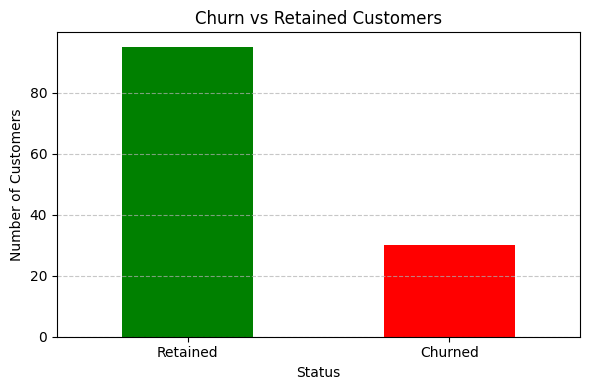

In [9]:
churn_counts = df['churn'].value_counts()

plt.figure(figsize=(6, 4))
churn_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Churn vs Retained Customers')
plt.xlabel('Status')
plt.ylabel('Number of Customers')
plt.xticks(ticks=[0, 1], labels=['Retained', 'Churned'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **STEP-4: TRAINING MODEL AND FINDING THE PERFORMANCE ACCURACY**

In [10]:
df_model = df.drop(['acc_creation_date', 'last_login','days_since_last_login'], axis=1)
#One-hot encode categorical columns
df_model = pd.get_dummies(df_model, drop_first=True)
#define target and features
X = df_model.drop('churn', axis=1)
y = df_model['churn']

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#handle missing values
#for numeric columns: fill with median
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numeric_cols] = X_train[numeric_cols].fillna(X_train[numeric_cols].median())
X_test[numeric_cols] = X_test[numeric_cols].fillna(X_train[numeric_cols].median())  # use training stats

#gor categorical columns,fill with 'Unknown'
categorical_cols = X_train.select_dtypes(include='object').columns
X_train[categorical_cols] = X_train[categorical_cols].fillna('Unknown')
X_test[categorical_cols] = X_test[categorical_cols].fillna('Unknown')

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

***LOGISTIC REGRESSION MODEL***

In [11]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
#prediction
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]
#classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nAUC-PR Score:", average_precision_score(y_test, y_prob))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))
print("\nLog Loss:", log_loss(y_test, y_prob))

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.70      0.89      0.78        18

    accuracy                           0.64        25
   macro avg       0.35      0.44      0.39        25
weighted avg       0.50      0.64      0.56        25

Confusion Matrix:
 [[ 0  7]
 [ 2 16]]

Accuracy Score: 0.64

AUC-PR Score: 0.7558584968510598

AUC-ROC Score: 0.41269841269841273

Log Loss: 0.8437706335149961


***XGBOOST MODEL***

In [12]:
# XGBoost Model Evaluation
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
# Prediction
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nAUC-PR Score:", average_precision_score(y_test, y_prob))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))
print("\nLog Loss:", log_loss(y_test, y_prob))

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.65      0.72      0.68        18

    accuracy                           0.52        25
   macro avg       0.33      0.36      0.34        25
weighted avg       0.47      0.52      0.49        25

Confusion Matrix:
 [[ 0  7]
 [ 5 13]]

Accuracy Score: 0.52

AUC-PR Score: 0.658420211738626

AUC-ROC Score: 0.30952380952380953

Log Loss: 1.650015557868374


***KNN***

In [13]:
# KNN Model Evaluation
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
# Prediction
y_pred = knn_model.predict(X_test_scaled)
y_prob = knn_model.predict_proba(X_test_scaled)[:, 1]
# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nAUC-PR Score:", average_precision_score(y_test, y_prob))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))
print("\nLog Loss:", log_loss(y_test, y_prob))

Classification Report:

              precision    recall  f1-score   support

           0       0.25      0.14      0.18         7
           1       0.71      0.83      0.77        18

    accuracy                           0.64        25
   macro avg       0.48      0.49      0.48        25
weighted avg       0.58      0.64      0.60        25

Confusion Matrix:
 [[ 1  6]
 [ 3 15]]

Accuracy Score: 0.64

AUC-PR Score: 0.7607108350586611

AUC-ROC Score: 0.5674603174603174

Log Loss: 2.010508037775184


***SVM***

In [14]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_scaled, y_train)
# Prediction
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]
# Evaluation Metrics
print("Classification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("\nAUC-PR Score:", average_precision_score(y_test, y_prob))
print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))
print("\nLog Loss:", log_loss(y_test, y_prob))

Classification Report:

              precision    recall  f1-score   support

           0       0.22      0.29      0.25         7
           1       0.69      0.61      0.65        18

    accuracy                           0.52        25
   macro avg       0.45      0.45      0.45        25
weighted avg       0.56      0.52      0.54        25

Confusion Matrix:
 [[ 2  5]
 [ 7 11]]

Accuracy Score: 0.52

AUC-PR Score: 0.7841454541235243

AUC-ROC Score: 0.4920634920634921

Log Loss: 0.642308573238437


# **STEP-5: COMPARATIVE ANALYSIS:**

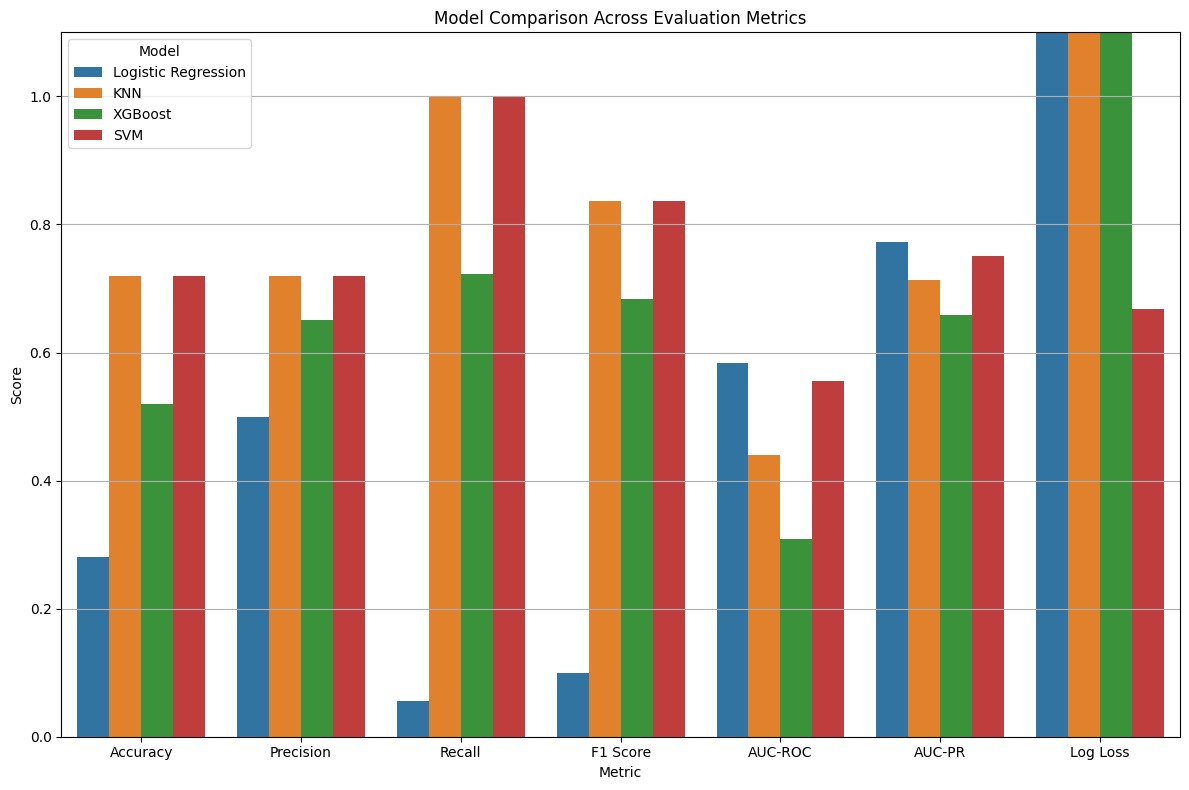

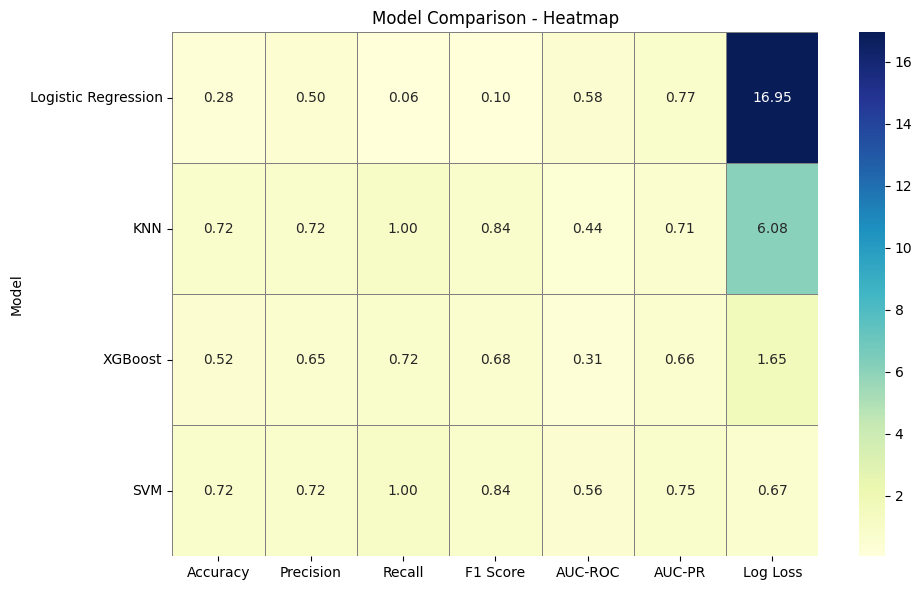

In [15]:
# Define models with their appropriate data
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), X_train_scaled),
    'KNN': (KNeighborsClassifier(n_neighbors=5), X_train_scaled),
    'XGBoost': (XGBClassifier(eval_metric='logloss'), X_train),
    'SVM': (SVC(probability=True, class_weight='balanced', random_state=42), X_train_scaled)
}

# Dictionary to store metrics
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC-ROC': [],
    'AUC-PR': [],
    'Log Loss':[]
}

# Evaluate each model
for name, (model, X_data) in models.items():
    model.fit(X_data, y_train)
    X_test_data = X_test_scaled if 'scaled' in X_data.columns else X_test
    y_pred = model.predict(X_test_data)
    y_prob = model.predict_proba(X_test_data)[:, 1]

    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))
    results['AUC-ROC'].append(roc_auc_score(y_test, y_prob))
    results['AUC-PR'].append(average_precision_score(y_test, y_prob))
    results['Log Loss'].append(log_loss(y_test, y_prob))

#Bar Plot
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'AUC-PR', 'Log Loss']
results_melted = results_df.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model')
plt.title("Model Comparison Across Evaluation Metrics")
plt.ylim(0, 1.1)
plt.legend(title="Model")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#HeatMap
plt.figure(figsize=(10, 6))
heatmap_data = results_df.set_index('Model')  # Set model names as index
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title("Model Comparison - Heatmap")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#palette:'crest','Set2','viridis','plasma','coolwarm','cubehelix'

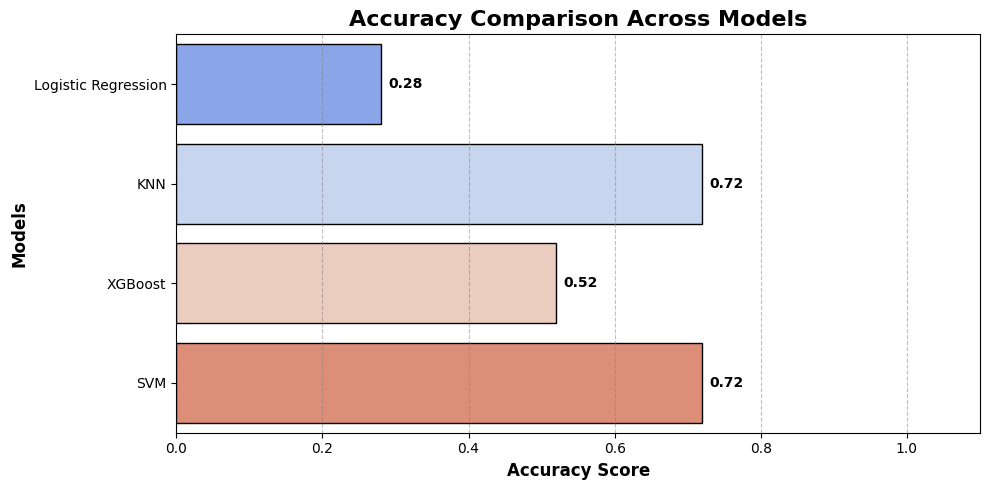

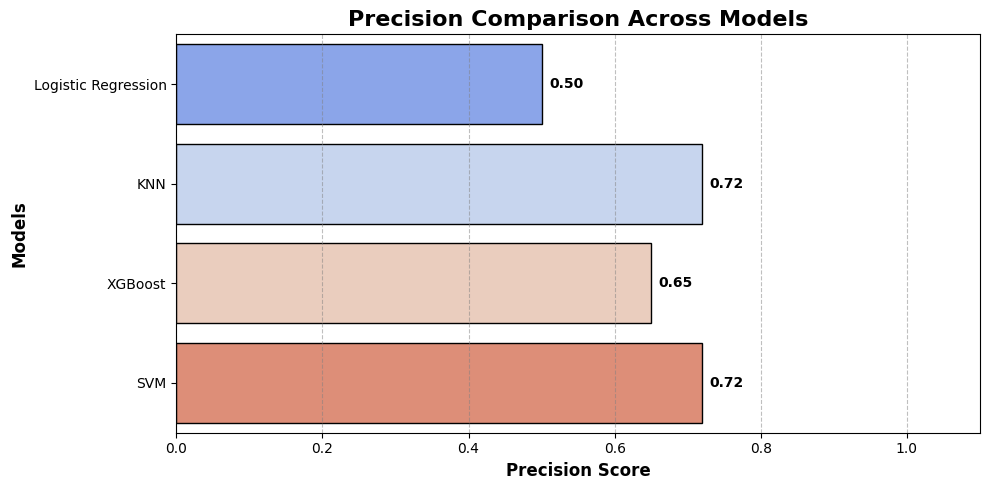

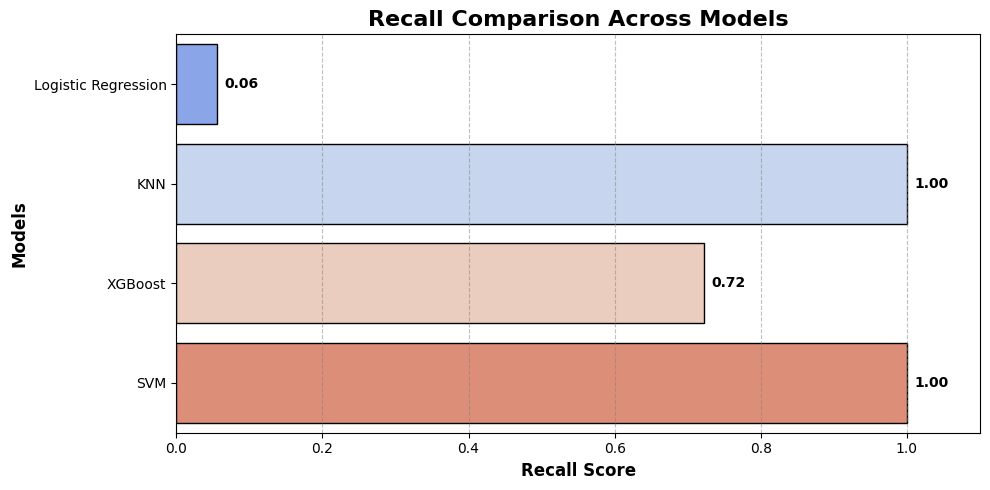

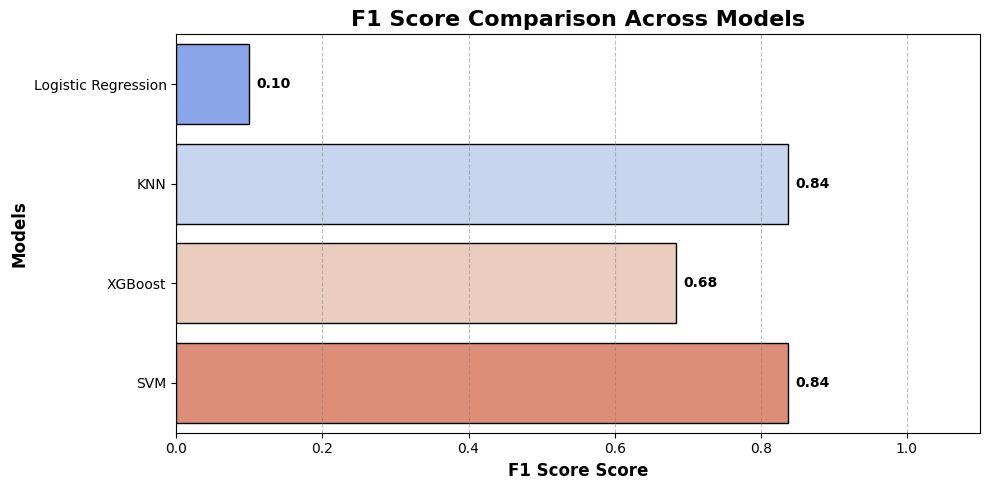

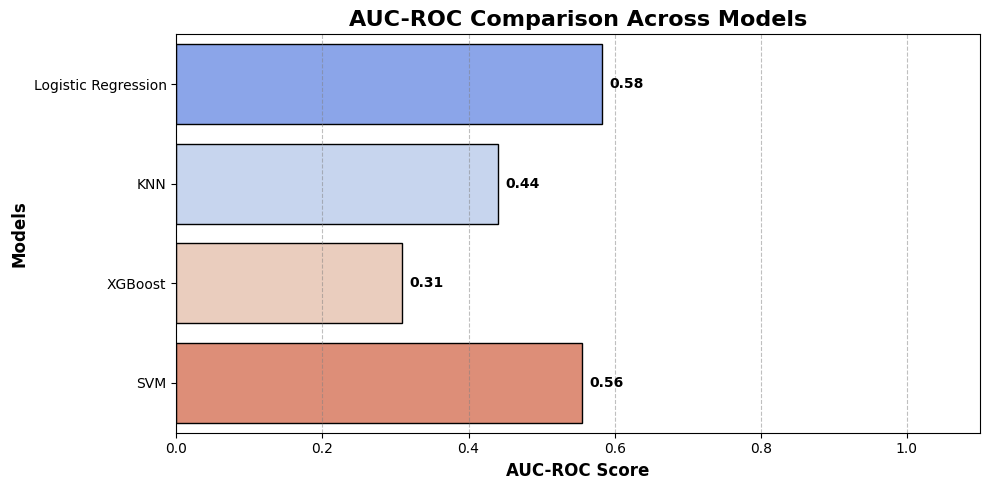

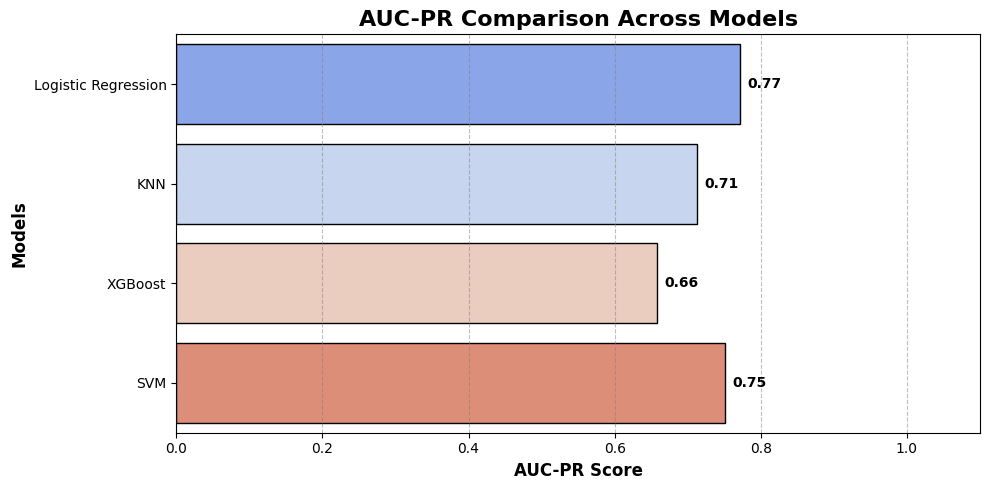

<ipython-input-16-c8d74bbed7f4>:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


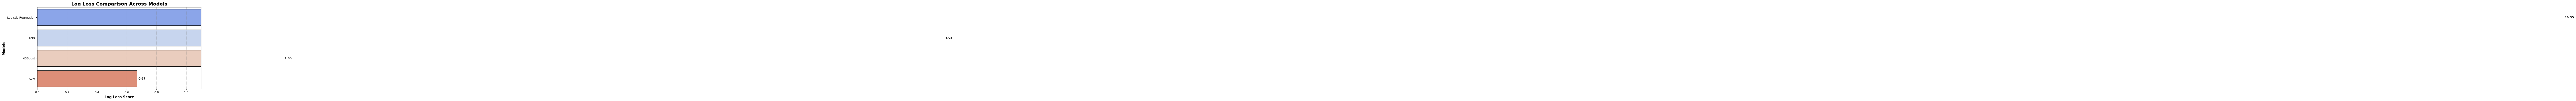

In [16]:
for metric in results_df.columns[1:]:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=metric, y='Model', data=results_df, palette='coolwarm', edgecolor='black', hue='Model')
    for index, value in enumerate(results_df[metric]):
        plt.text(value + 0.01, index, f'{value:.2f}', va='center', color='black', weight='bold')
    plt.title(f"{metric} Comparison Across Models", fontsize=16, weight='bold')
    plt.xlabel(f'{metric} Score', fontsize=12, weight='bold')
    plt.ylabel('Models', fontsize=12, weight='bold')
    plt.xlim(0, 1.1)
    plt.grid(axis='x', linestyle='--', alpha=0.5, color='gray')
    plt.tight_layout()
    plt.show()